This is my final project for CSCA-5632 Unsupervised Algorithms in Machine Learning at CU Boulder. In it, I will be working with the Fashion MNIST dataset, freely available on Kaggle (https://www.kaggle.com/datasets/zalando-research/fashionmnist). The dataset is comprised of 70,000 28x28px grayscale images of various clothing items. My goal is to explore and analyze the data using various unsupervised learning techniques such as dimensionality reduction and clustering. Through these, I aim to uncover various patterns and similarities between different types of clothing. Naturally, I will avoid using labels in my analysis.

The Jupyter Notebook, along with its data files, will be available in the following GitHub repo: https://github.com/giosofteng/fa .

Let us begin by importing our dataset (stored as 2 CSV files).

In [1]:
import pandas as pd

# load train and test data
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

# print first few rows of data
print(f'Train data:\n{data_train.head()}')
print(f'Test data:\n{data_test.head()}')

Train data:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0       

As we can see, the labels here are presented as integers, which make them difficult to interpret. Let us change them to their textual representations.

In [2]:
map_label = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
data_train['label'] = data_train['label'].map(map_label)
data_test['label'] = data_test['label'].map(map_label)

# print altered rows
print(data_train.head())
print(data_test.head())

         label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0     Pullover       0       0       0       0       0       0       0   
1   Ankle boot       0       0       0       0       0       0       0   
2        Shirt       0       0       0       0       0       0       0   
3  T-shirt/top       0       0       0       1       2       0       0   
4        Dress       0       0       0       0       0       0       0   

   pixel8  pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0       0  ...         0         0         0         0         0   
1       0       0  ...         0         0         0         0         0   
2       5       0  ...         0         0         0        30        43   
3       0       0  ...         3         0         0         0         0   
4       0       0  ...         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0   

Much better! Let us continue the data cleaning process by checking for duplicate rows and removing any we find.

In [3]:
# check for duplicates in train and test data
duplicates_train = data_train.duplicated().sum()
print(f'Train data duplicate row count: {duplicates_train}')
duplicates_test = data_test.duplicated().sum()
print(f'Test data duplicate row count: {duplicates_test}')

Train data duplicate row count: 43
Test data duplicate row count: 1


In [4]:
# remove duplicates in train and test data
data_train = data_train.drop_duplicates()
data_test = data_test.drop_duplicates()

# print new duplicate counts
duplicates_train = data_train.duplicated().sum()
duplicates_test = data_test.duplicated().sum()
print(f'Train data duplicate row count post-removal: {duplicates_train}')
print(f'Test data duplicate row count post-removal: {duplicates_test}')

Train data duplicate row count post-removal: 0
Test data duplicate row count post-removal: 0


Great! Let us now make sure that our data is properly formatted. We will separate the labels from the features, normalize pixel values, and flatten image data. Normalizing the pixel values to a [0, 1] range will help our clustering and dimensionality reduction algorithms. They will also reduce the impact of large pixel value differences (e.g. 32 vs 128). Reinterpreting the 2D image data as a 1D array of 784 (28x28) features will also help several algorithms, such as k-means.

In [5]:
# separate labels and features
y_train = data_train['label']
X_train = data_train.drop('label', axis=1)
y_test = data_test['label']
X_test = data_test.drop('label', axis=1)

# normalize pixel values
X_train /= 255.0
X_test /= 255.0

# flatten and store pixel data as 1D arrays of 784 pixels
X_train = X_train.values.reshape(-1, 28*28)
X_test = X_test.values.reshape(-1, 28*28)

# print data shape
print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (59957, 784)
Test data shape: (9999, 784)


With our data clean and properly formatted, let us perform some EDA to get a better overview of it.

To start, let us display some sample images from the dataset, along with their labels.

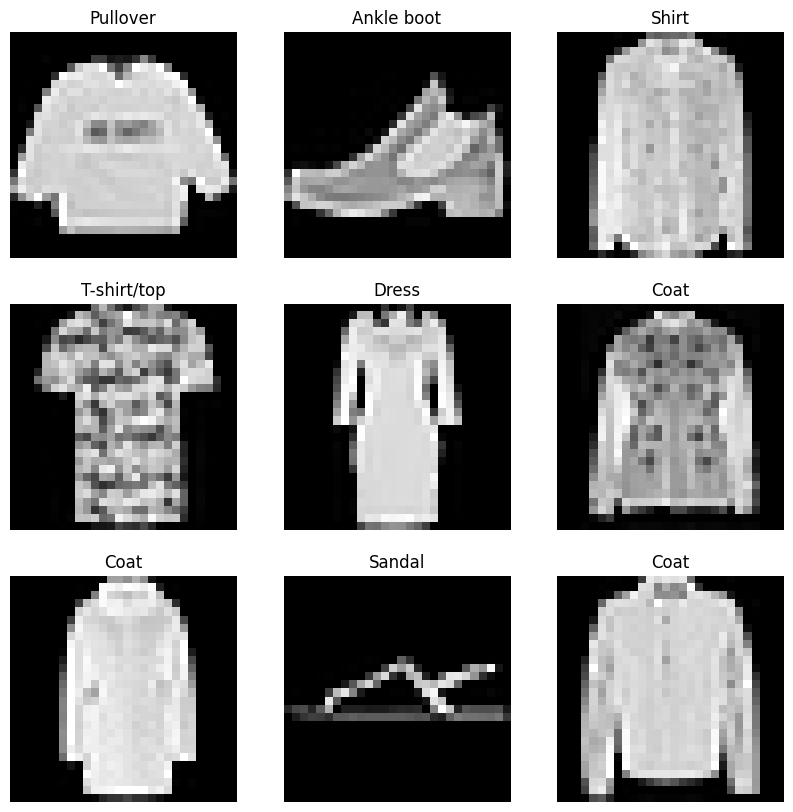

In [6]:
import matplotlib.pyplot as plt

images = X_train[:9]
labels = y_train[:9]
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

Everything seems to be in order! Let us now plot the class distribution—make sure our data is evenly distributed across all labels.

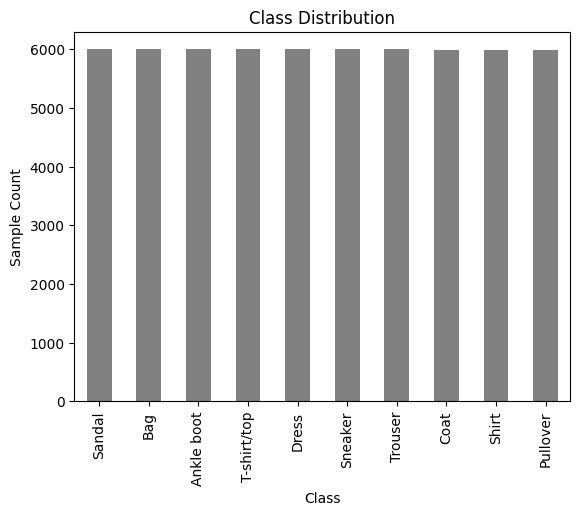

In [7]:
y_train.value_counts().plot(kind='bar', color='gray')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.show()

We seem to be dealing with a very even dataset, which is certainly good news. While we are at it, let us also check the pixel value distribution, getting a better idea of our images’ brightness and contrast.

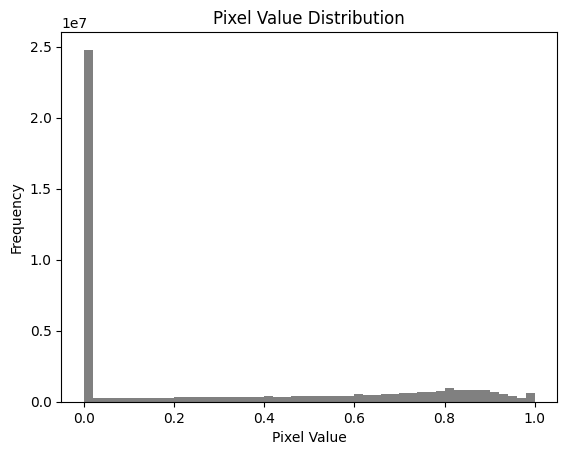

In [8]:
plt.hist(X_train.flatten(), bins=50, color='gray')
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

It seems that the color black dominates our image data. This is by no means uncommon. Otherwise, the distribution seems normal. Lastly, let us also display some basic statistics for our pixel values.

In [9]:
print(f'Mean pixel value: {X_train.mean():.2f}')
print(f'Standard deviation of pixel values: {X_train.std():.2f}')

Mean pixel value: 0.29
Standard deviation of pixel values: 0.35


So, as the graphs indicated, our images appear to be quite dark. Still, with a moderate standard deviation, we seem to be working with all sorts of color intensities, which certainly mimics the wide range of appearances that real clothes can have.

With EDA behind us, let us actually implement some unsupervised learning techniques!

Let us begin our analysis by applying k-means clustering, attempting to group the images together based on pixel value similarities. By successfully clustering the images, we will have uncovered distinct image groups that will correspond to different clothing types—all without using labels.

In [10]:
from sklearn.cluster import KMeans

# choose 10 clusters--one for each clothing category
model_kmeans = KMeans(n_clusters=10, random_state=42)
model_kmeans.fit(X_train)

# predict cluster labels for training data
labels = model_kmeans.predict(X_train)

Now let us evaluate the clustering quality using inertia (measuring how tight our clusters are) and silhouette score (measuring how well our clusters are formed).

In [11]:
from sklearn.metrics import silhouette_score

# print inertia--sum of images' squared distances to their closest cluster centers
print(f'Inertia: {model_kmeans.inertia_:.2f}')

# print silhouette score--how similar images are to their clusters compared to other clusters
print(f'Silhouette score: {silhouette_score(X_train, labels):.2f}')

Inertia: 1904516.59
Silhouette score: 0.15


Let us also visualize our clusters by displaying 10 images from each.

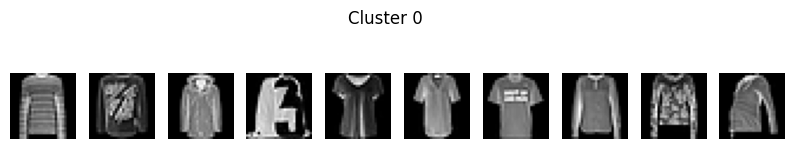

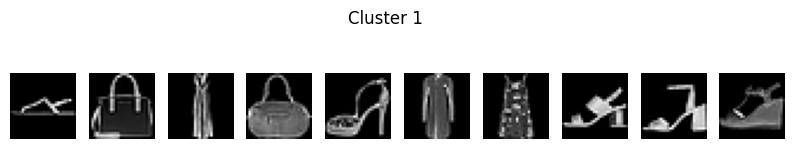

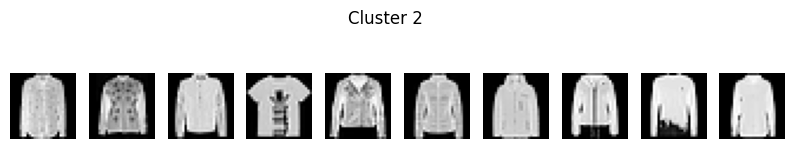

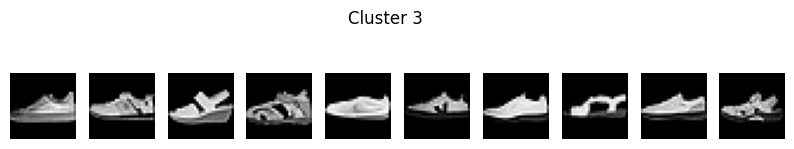

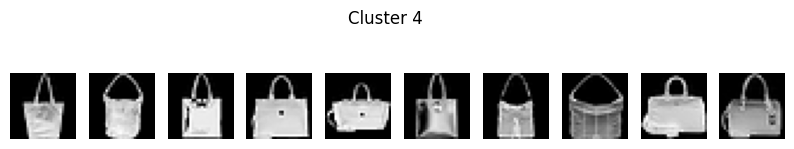

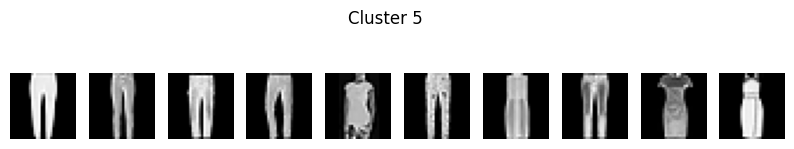

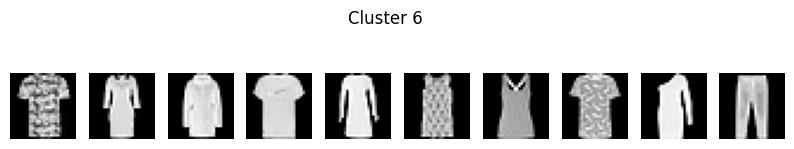

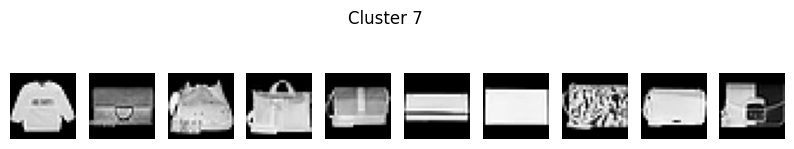

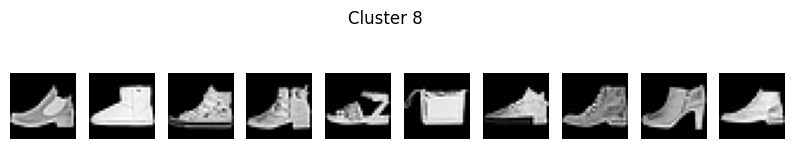

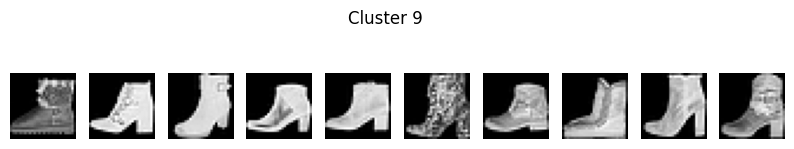

In [12]:
for i in range(10):
    plt.figure(figsize=(10,2))
    images = X_train[labels == i]
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.imshow(images[j].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()

As can be seen, our results are decent, but leave some room for improvement.

Let us try to improve cluster separation via dimensionality reduction using PCA (Principal Component Analysis).

Inertia: 782437.33
Silhouette score: 0.27


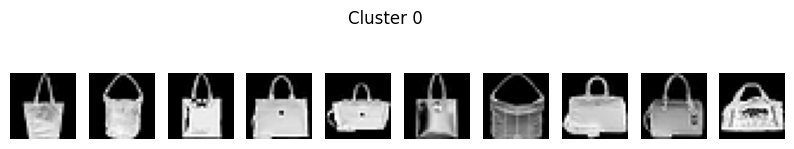

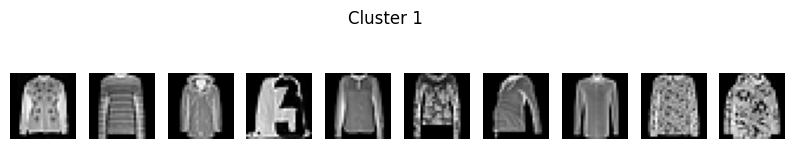

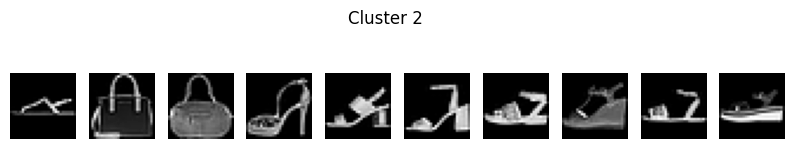

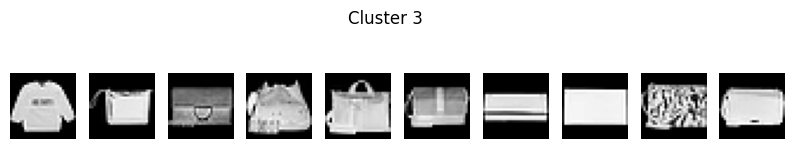

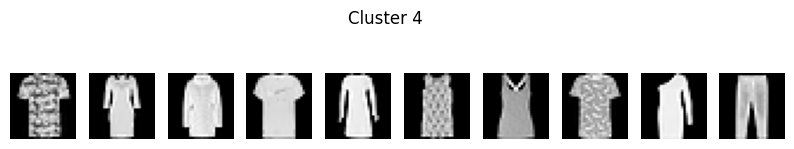

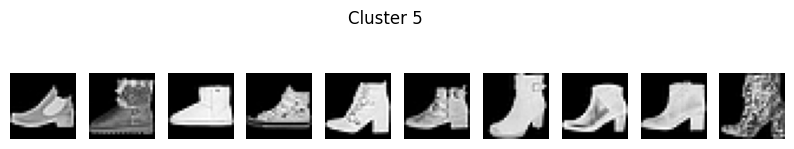

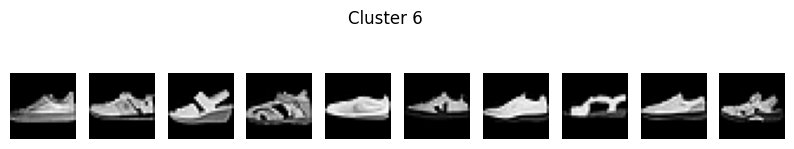

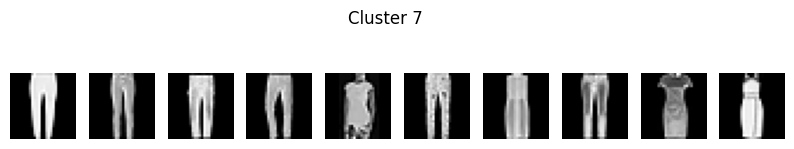

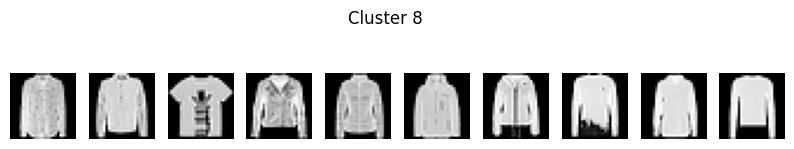

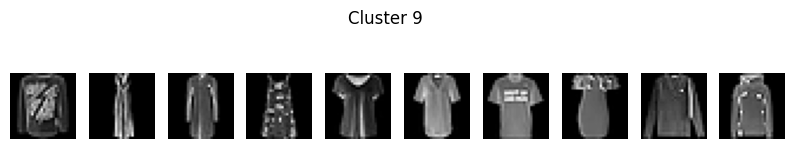

In [13]:
from sklearn.decomposition import PCA

# reduce current 784 dimensions to 10 components
model_pca = PCA(n_components=10, random_state=42)
X_train_pca = model_pca.fit_transform(X_train)

# following code remains largely the same
model_kmeans.fit(X_train_pca)
labels = model_kmeans.predict(X_train_pca)
print(f'Inertia: {model_kmeans.inertia_:.2f}')
print(f'Silhouette score: {silhouette_score(X_train_pca, labels):.2f}')
for i in range(10):
    plt.figure(figsize=(10,2))
    images = X_train[labels == i]
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.imshow(images[j].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()

Definitely an improvement! In addition to more cohesive results that can be seen through the visualization, the lower inertia tells us that data points are now closer to their assigned cluster centroids, while the increase in silhouette score indicates that cluster separation has improved.

Let us also visualize the clusters themselves in 2D space using t-SNE (t-Distributed Stochastic Neighbor Embedding).

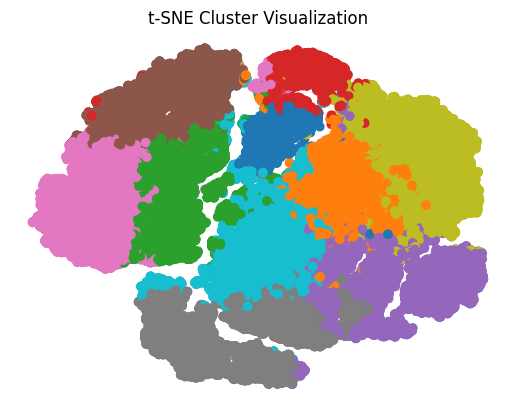

In [14]:
from sklearn.manifold import TSNE

# use 2 components to display in 2D space
model_tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = model_tsne.fit_transform(X_train_pca)

plt.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=labels, cmap='tab10')
plt.title('t-SNE Cluster Visualization')
plt.axis('off')
plt.show()

Not bad at all! But let us also try some other clustering methods to hopefully get even better results.

Since we are working with image data, we would benefit from a method that handles high-dimensional data and can capture complex structures well. GMM (Gaussian Mixture Model) seems like a sensible choice. Let us implement it next.

In [15]:
from sklearn.mixture import GaussianMixture

# again choose 10 clusters
model_gmm = GaussianMixture(n_components=10, random_state=42)
model_gmm.fit(X_train_pca)
labels = model_gmm.predict(X_train_pca)

As for the result analysis and visualization, we can again rely on the silhouette score and visualize the clusters in 2D space via t-SNE. The only difference is that we no longer have access to inertia. However, we can check the log-likelihood to see how well our model fits the data.

Log-likelihood: -11.71
Silhouette score: 0.17


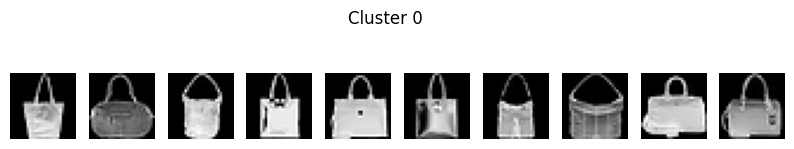

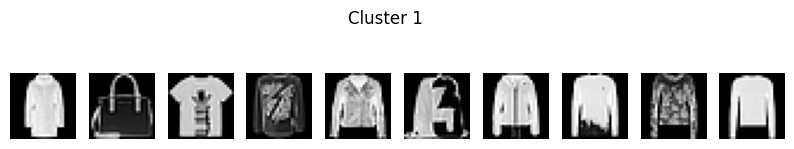

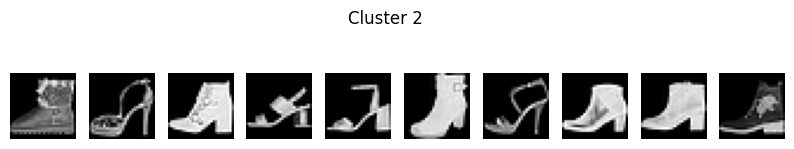

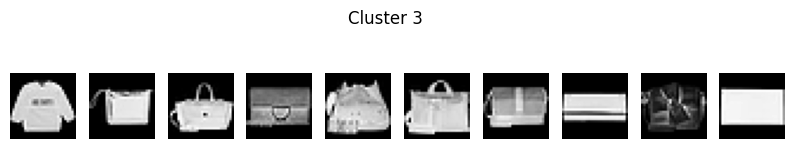

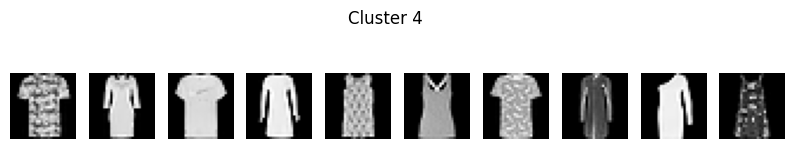

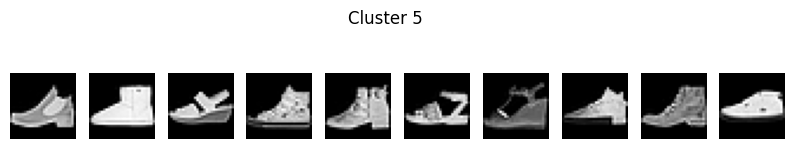

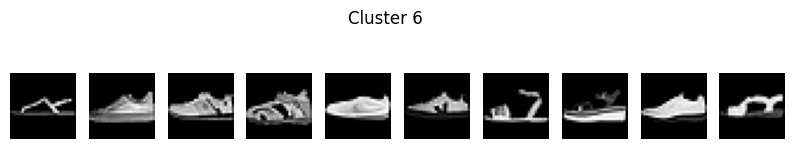

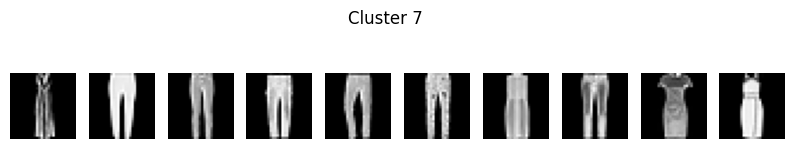

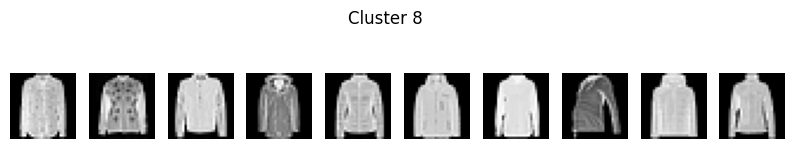

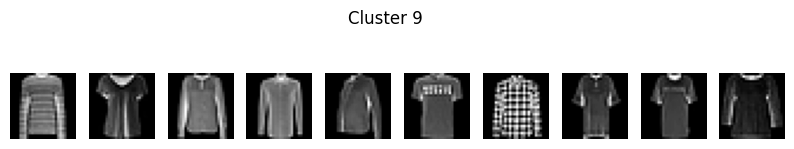

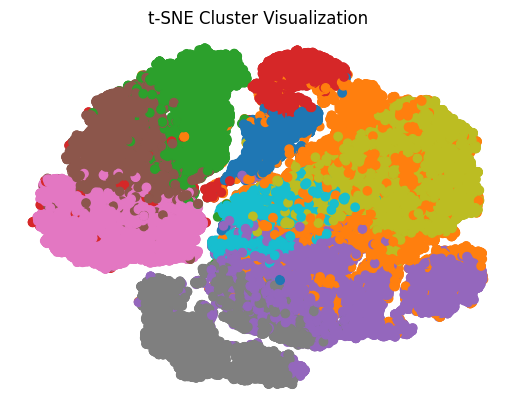

In [16]:
print(f'Log-likelihood: {model_gmm.score(X_train_pca):.2f}')
print(f'Silhouette score: {silhouette_score(X_train_pca, labels):.2f}')

for i in range(10):
    plt.figure(figsize=(10,2))
    images = X_train[labels == i]
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.imshow(images[j].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()

plt.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=labels, cmap='tab10')
plt.title('t-SNE Cluster Visualization')
plt.axis('off')
plt.show()

Curiously, GMM gave us worse results than the simpler k-means! Changing PCA component count did not lead to any improvement either.

Let us finish things off by applying one more clustering method to our data—spectral clustering. It handles high-dimensional data (such as images) quite well and on paper, ought to give us better results than k-means.

Silhouette score: 0.23


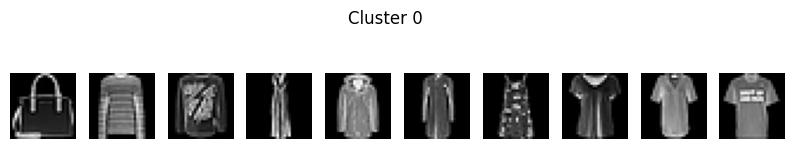

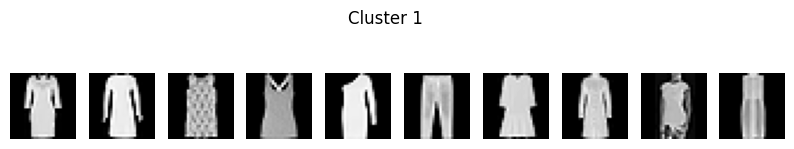

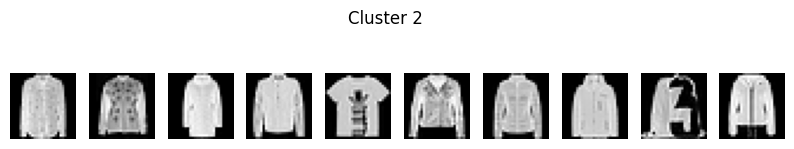

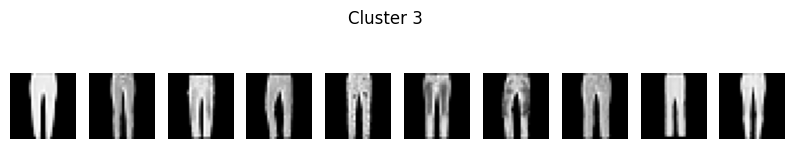

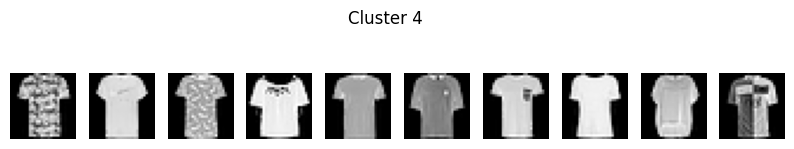

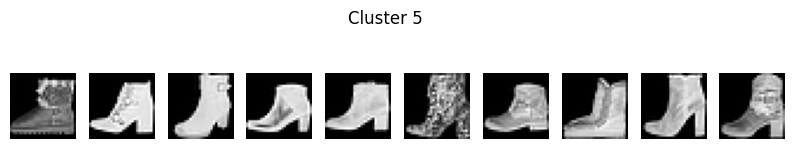

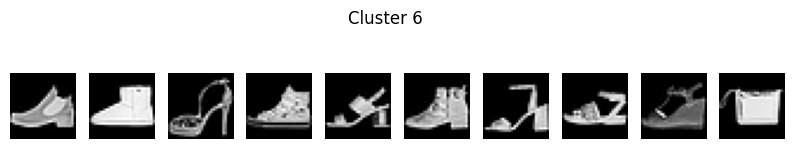

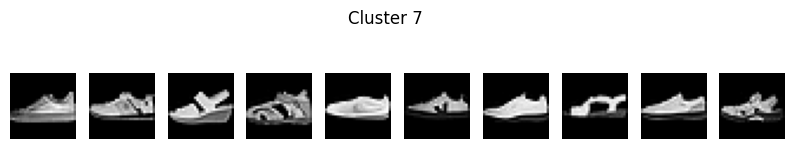

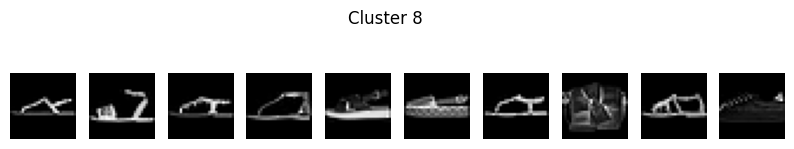

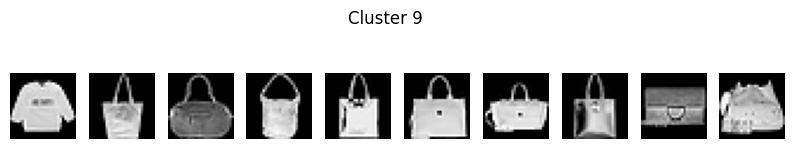

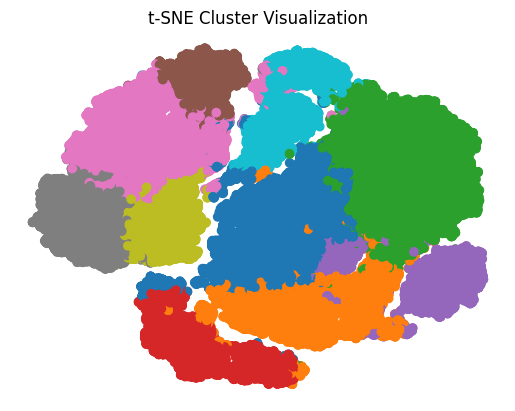

In [17]:
from sklearn.cluster import SpectralClustering

# again choose 10 clusters
# !NOTE! this method is very slow; `affinity` and `n_jobs` parameters improve performance
model_spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', n_jobs=8, random_state=42)
labels = model_spectral.fit_predict(X_train_pca)

# measure performance; same code as before
print(f'Silhouette score: {silhouette_score(X_train_pca, labels):.2f}')

for i in range(10):
    plt.figure(figsize=(10,2))
    images = X_train[labels == i]
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.imshow(images[j].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()

plt.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=labels, cmap='tab10')
plt.title('t-SNE Cluster Visualization')
plt.axis('off')
plt.show()

Curiously, this other, more image-appropriate method also did not improve our results. It definitely did better than GMM, but still no better than our simple k-means. Parameter tuning did not yield any improvements here either.

To conclude our quick foray into image data clustering, let us summarize our process and results. We started with some simple data pre-processing, such as dropping duplicate rows, separating features from labels, normalizing pixel values, and flattening our pixel data into 1D arrays of 784 pixel values. We then did some simple EDA to get a better overview of what we were working with and seeing no anomalies, proceeded with model building and result analysis. We started with a simple k-means approach and got decent results. Most of our unlabeled data was correctly classified into 10 distinct clusters—each representing one of the labels. We then improved our results via dimensionality reduction using PCA. However, our subsequent attempts at improving our model’s accuracy were unsuccessful. GMM gave us worse results, despite generally being better when dealing with complex, multi-dimensional data. We got better results with spectral clustering, but still did not manage to improve our k-means accuracy. One takeaway from all of this is that, combined with PCA, k-means is a rather effective means of clustering image data. In the future, I would love to compare it against even more clustering methods to see if it really is the best choice for such scenarios.